In [40]:
import sys
import os
import six
sys.path.insert(0,"../")
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm
from scipy.integrate import quad, dblquad
from utils import lddmm_utils, mesh_processing, sph_utils
import open3d as o3d

import numpy as np
import trimesh as tri
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pyssht

In [41]:
def get_data(file):
    mesh = o3d.io.read_triangle_mesh(file)
    V, F, Rho = mesh_processing.getDataFromMesh(mesh)
    return(V,F,Rho)

V,F,Rho = get_data("../data/test_data/bunny.ply")

sphere = tri.creation.uv_sphere(count=[32, 32])
mesh = tri.Trimesh(V,F)
new_mesh_V, new_mesh_F = mesh_processing.decimate_mesh(V,F,target = 1776)
new_mesh = tri.Trimesh(vertices = new_mesh_V, faces = new_mesh_F)

print("mesh: ", new_mesh_V[:,0].shape)
print("sphere: ", sphere.vertices.shape)

mesh:  (2016,)
sphere:  (2016, 3)


In [42]:
new_mesh_V[:,0] = (new_mesh_V[:,0] - new_mesh_V[:,0].mean()) / new_mesh_V[:,2].max(axis=0)
new_mesh_V[:,1] = (new_mesh_V[:,1] - new_mesh_V[:,1].mean()) / new_mesh_V[:,2].max(axis=0)
new_mesh_V[:,2] = (new_mesh_V[:,2] - new_mesh_V[:,2].mean()) / new_mesh_V[:,2].max(axis=0)

new_mesh = tri.Trimesh(vertices = new_mesh_V, faces = new_mesh_F)

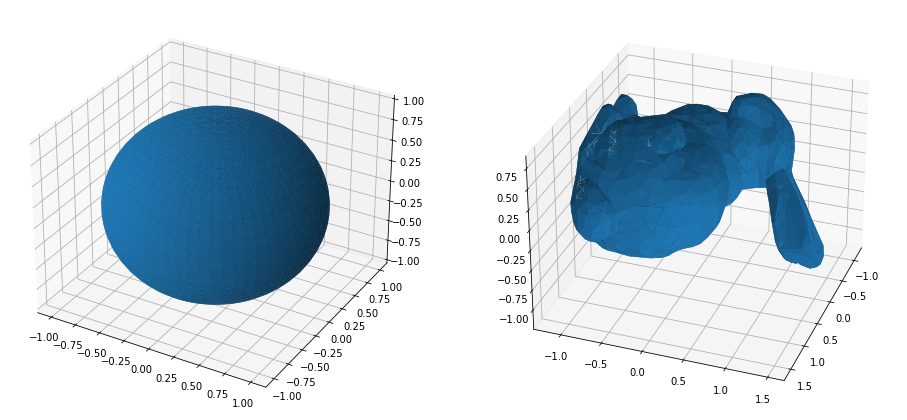

In [43]:
(x_mesh, y_mesh, z_mesh) = new_mesh_V[:,0], new_mesh_V[:,1], new_mesh_V[:,2]
x, y ,z = np.array(sphere.vertices[:,0]), np.array(sphere.vertices[:,1]), np.array(sphere.vertices[:,2])
(r, theta, phi) = pyssht.cart_to_spherical(x, y, z)

fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(x, y, triangles=sphere.faces, Z=z)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(x_mesh, y_mesh, triangles=new_mesh_F, Z=z_mesh)
ax2.view_init(30, 20)

plt.show()

In [44]:
n = 16
my_basis = sph_utils.SphHarmBasis(n_coeffs=n) # NEED TO BE A SQUARE NUMBER

def my_sphere_function_x(theta, phi):
    return np.sin(theta)*np.cos(phi)

def my_sphere_function_y(theta, phi):
    return np.sin(theta)*np.sin(phi)

def my_sphere_function_z(theta, phi):
    return np.cos(theta)

my_coeffs_x = my_basis.sph_harm_transform(my_sphere_function_x)
my_coeffs_y = my_basis.sph_harm_transform(my_sphere_function_y)
my_coeffs_z = my_basis.sph_harm_transform(my_sphere_function_z)

my_reconstr_function_x = my_basis.sph_harm_reconstruct(my_coeffs_x)
my_reconstr_function_y = my_basis.sph_harm_reconstruct(my_coeffs_y)
my_reconstr_function_z = my_basis.sph_harm_reconstruct(my_coeffs_z)

In [45]:
f_recons_x = my_reconstr_function_x(theta,phi)
f_recons_y = my_reconstr_function_y(theta,phi)
f_recons_z = my_reconstr_function_z(theta,phi)

In [46]:
(x_coord_recons, y_coord_recons, z_coord_recons) = f_recons_x, f_recons_y, f_recons_z

In [47]:
#setting up the faces for the mesh

listpq = np.array([x_coord_recons, y_coord_recons, z_coord_recons])
rows_unique = np.unique(listpq.T, axis=0, return_index=True)
new = listpq.T[rows_unique[1]]
hull = tri.convex.convex_hull(new, qhull_options='QbB Pp Qt QJ')
faces = hull.faces

Text(0.5, 0.92, 'Unit sphere mesh')

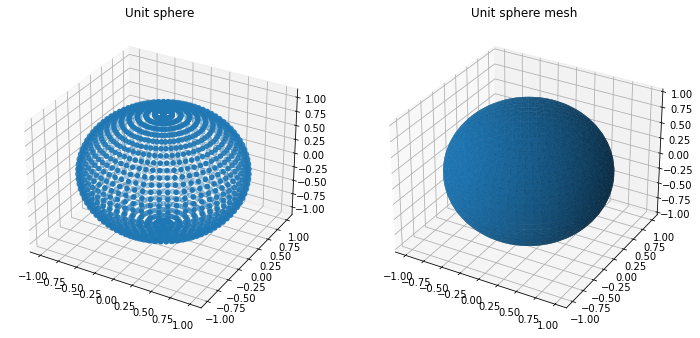

In [48]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_coord_recons, y_coord_recons, z_coord_recons)
ax1.set_title("Unit sphere")
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(new[:,0], new[:,1], triangles = faces, Z = new[:,2])
ax2.set_title("Unit sphere mesh")

## Bunny noise

In [10]:
n = 49
t = 1
listpq = []

lambdas = np.array([1/(np.sqrt(k+1)) for k in range (0,n)])
Q = np.diag(lambdas) #covariance operator
Q = np.eye(n)

my_basis = sph_utils.SphHarmBasis(n_coeffs=n) # NEED TO BE A SQUARE NUMBER

def my_sphere_function_x_noise(theta, phi):
    return 0.000001*np.sin(theta)*np.cos(phi)

def my_sphere_function_y_noise(theta, phi):
    return 0.000001*np.sin(theta)*np.sin(phi)

def my_sphere_function_z_noise(theta, phi):
    return 0.000001*np.cos(theta)

my_coeffs_x = my_basis.sph_harm_transform(my_sphere_function_x_noise)
my_coeffs_y = my_basis.sph_harm_transform(my_sphere_function_y_noise)
my_coeffs_z = my_basis.sph_harm_transform(my_sphere_function_z_noise)

my_reconstr_stoch_x = my_basis.sph_harm_reconstruct_random(my_coeffs_x, Q, t, theta = theta, phi = phi, n_step = 50)
my_reconstr_stoch_y = my_basis.sph_harm_reconstruct_random(my_coeffs_y, Q, t, theta = theta, phi = phi, n_step = 50)
my_reconstr_stoch_z = my_basis.sph_harm_reconstruct_random(my_coeffs_z, Q, t, theta = theta, phi = phi, n_step = 50)

f_stoch_x = my_reconstr_stoch_x
f_stoch_y = my_reconstr_stoch_y
f_stoch_z = my_reconstr_stoch_z

In [11]:
x_list = np.array([x_mesh + f_stoch_x[0:][j] for j in range(f_stoch_x[0:][:].shape[0])])
y_list = np.array([y_mesh + f_stoch_y[0:][j] for j in range(f_stoch_y[0:][:].shape[0])])
z_list = np.array([z_mesh + f_stoch_z[0:][j] for j in range(f_stoch_z[0:][:].shape[0])])

for t in range(f_stoch_x.shape[0]):
    (x_coord_stoch, y_coord_stoch, z_coord_stoch) = x_list[t], y_list[t], z_list[t]
    listpq.append([x_coord_stoch, y_coord_stoch, z_coord_stoch])
        
listpq = np.array(listpq)

In [12]:
rows_unique = np.unique(listpq[0,:,:].T, axis=0, return_index=True)
new = listpq[0,:,:].T[rows_unique[1]]
hull = tri.convex.convex_hull(new, qhull_options='QbB Pp Qt QJ')
faces = hull.faces

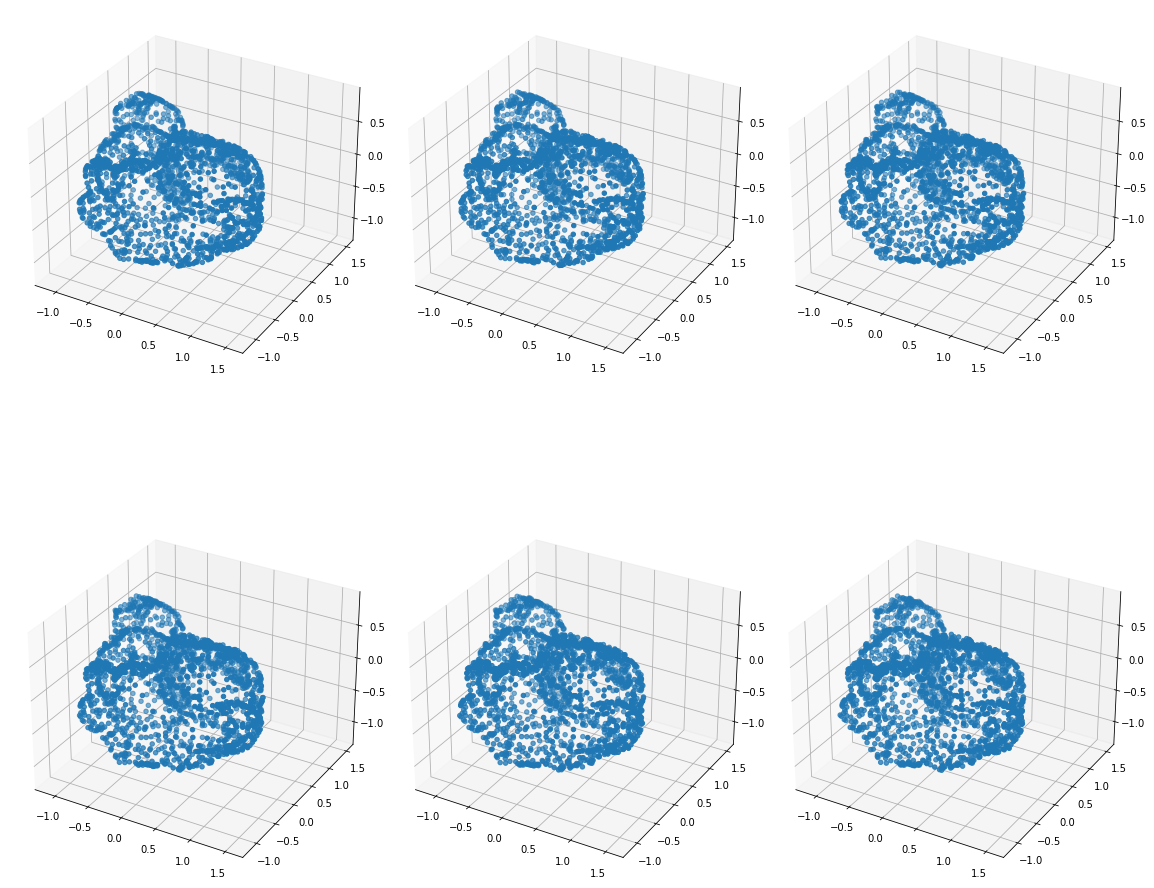

In [13]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(231, projection='3d')
ax1.scatter(listpq[0,0,:], listpq[0,1,:], listpq[0,2,:])

ax2 = fig.add_subplot(232, projection='3d')
ax2.scatter(listpq[1,:,:].T[rows_unique[1]][:,0], listpq[1,:,:].T[rows_unique[1]][:,1], listpq[1,:,:].T[rows_unique[1]][:,2])

ax3 = fig.add_subplot(233, projection='3d')
ax3.scatter(listpq[2,:,:].T[rows_unique[1]][:,0], listpq[2,:,:].T[rows_unique[1]][:,1], listpq[2,:,:].T[rows_unique[1]][:,2])

ax4 = fig.add_subplot(234, projection='3d')
ax4.scatter(listpq[3,:,:].T[rows_unique[1]][:,0], listpq[3,:,:].T[rows_unique[1]][:,1], listpq[3,:,:].T[rows_unique[1]][:,2])

ax5 = fig.add_subplot(235, projection='3d')
ax5.scatter(listpq[4,:,:].T[rows_unique[1]][:,0], listpq[4,:,:].T[rows_unique[1]][:,1], listpq[4,:,:].T[rows_unique[1]][:,2])

ax6 = fig.add_subplot(236, projection='3d')
ax6.scatter(listpq[5,:,:].T[rows_unique[1]][:,0], listpq[5,:,:].T[rows_unique[1]][:,1], listpq[5,:,:].T[rows_unique[1]][:,2])

plt.tight_layout()
plt.show()

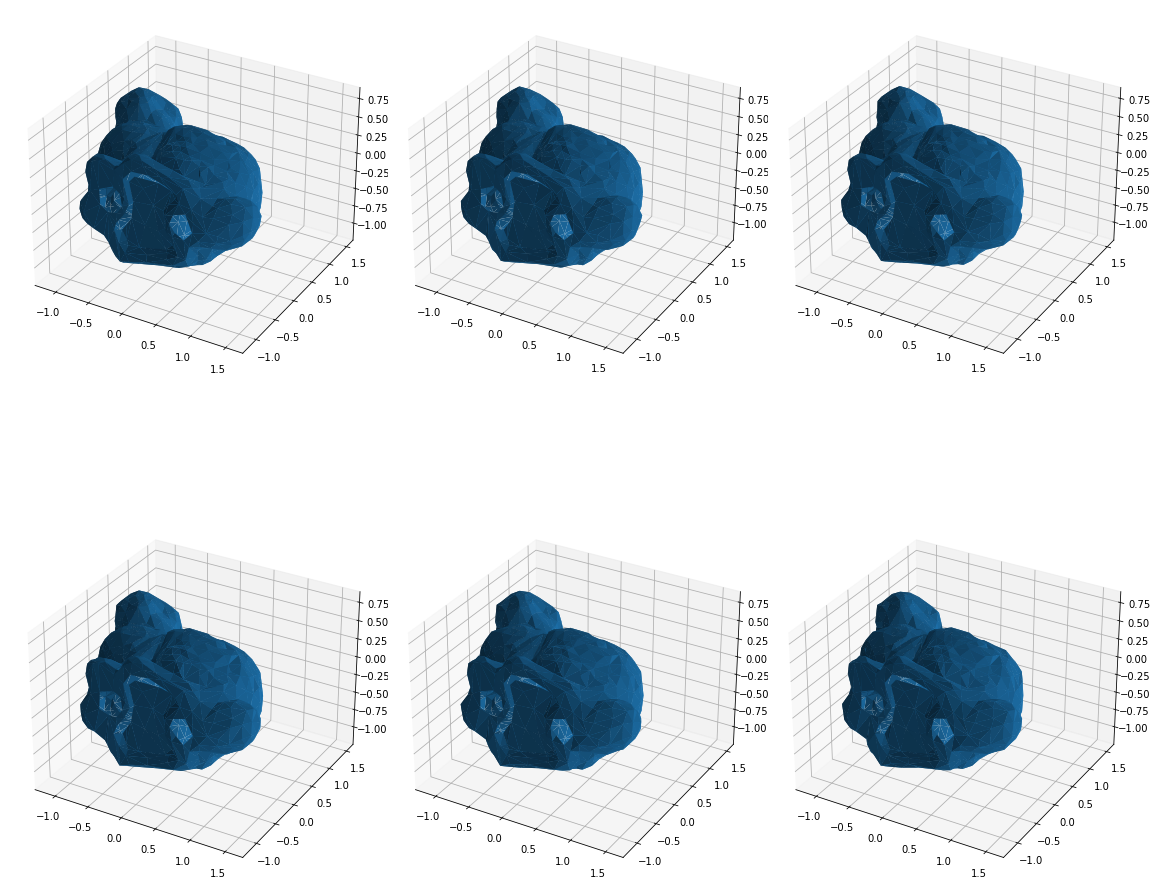

In [14]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(231, projection='3d')
ax1.plot_trisurf(listpq[0,0,:], listpq[0,1,:], triangles=new_mesh_F, Z=listpq[0,2,:])

ax2 = fig.add_subplot(232, projection='3d')
ax2.plot_trisurf(listpq[1,0,:], listpq[1,1,:], triangles=new_mesh_F, Z=listpq[1,2,:])

ax3 = fig.add_subplot(233, projection='3d')
ax3.plot_trisurf(listpq[2,0,:], listpq[2,1,:], triangles=new_mesh_F, Z=listpq[2,2,:])

ax4 = fig.add_subplot(234, projection='3d')
ax4.plot_trisurf(listpq[3,0,:], listpq[3,1,:], triangles=new_mesh_F, Z=listpq[3,2,:])

ax5 = fig.add_subplot(235, projection='3d')
ax5.plot_trisurf(listpq[4,0,:], listpq[4,1,:], triangles=new_mesh_F, Z=listpq[4,2,:])

ax6 = fig.add_subplot(236, projection='3d')
ax6.plot_trisurf(listpq[5,0,:], listpq[5,1,:], triangles=new_mesh_F, Z=listpq[5,2,:])

plt.tight_layout()
plt.show()

In [96]:
list_data = listpq
file_dir = "tests/bunny_process"
file_name = "Q_identity_49coeffs.gif"
auto_scale = True

from matplotlib.collections import PolyCollection
import imageio

In [81]:
filenames = []
listpq = list_data
steps = []
#setting up the faces for the mesh
#rows_unique = np.unique(listpq[0,:,:].T, axis=0, return_index=True)
#new = listpq[0,:,:].T[rows_unique[1]]
#hull = tri.convex.convex_hull(new, qhull_options='QbB Pp Qt QJ')
faces = new_mesh_F
#for i in range(listpq.shape[0]):
#    steps.append(listpq[i,:,:].T[rows_unique[1]])
#steps = np.array(steps)
if not auto_scale:
    scale = np.max(steps[-1].max(0)-steps[-1].min(0))
    
for i in range(len(listpq)):

    def frustum(left, right, bottom, top, znear, zfar):
        M = np.zeros((4, 4), dtype=np.float32)
        M[0, 0] = +2.0 * znear / (right - left)
        M[1, 1] = +2.0 * znear / (top - bottom)
        M[2, 2] = -(zfar + znear) / (zfar - znear)
        M[0, 2] = (right + left) / (right - left)
        M[2, 1] = (top + bottom) / (top - bottom)
        M[2, 3] = -2.0 * znear * zfar / (zfar - znear)
        M[3, 2] = -1.0
        return M
    def perspective(fovy, aspect, znear, zfar):
        h = np.tan(0.5*np.radians(fovy)) * znear
        w = h * aspect
        return frustum(-w, w, -h, h, znear, zfar)
    def translate(x, y, z):
        return np.array([[1, 0, 0, x], [0, 1, 0, y],
                         [0, 0, 1, z], [0, 0, 0, 1]], dtype=float)
    def xrotate(theta):
        t = np.pi * theta / 180
        c, s = np.cos(t), np.sin(t)
        return np.array([[1, 0,  0, 0], [0, c, -s, 0],
                         [0, s,  c, 0], [0, 0,  0, 1]], dtype=float)
    def yrotate(theta):
        t = np.pi * theta / 180
        c, s = np.cos(t), np.sin(t)
        return  np.array([[ c, 0, s, 0], [ 0, 1, 0, 0],
                          [-s, 0, c, 0], [ 0, 0, 0, 1]], dtype=float)

    def zrotate(theta):
        t = np.pi * theta / 180
        c, s = np.cos(t), np.sin(t)
        return  np.array([[ c, -s, 0, 0], [ s, c, 0, 0],
                          [0, 0, 1, 0], [ 0, 0, 0, 1]], dtype=float)

    V = np.array(listpq[i,:,:]).T
    #V = np.array([it[:,0], it[:,1], it[:,2]]).T
    F = np.array([faces[:,0], faces[:,1], faces[:,2]]).T

    if auto_scale:
        V = (V-(V.max(0)+V.min(0))/2)/max(V.max(0)-V.min(0))
    else:
        V = (V-(V.max(0)+V.min(0))/2)/scale
    MVP = perspective(25,1,1,100) @ translate(0,0,-3.5) @ xrotate(20) @ yrotate(20) @ zrotate(-10)
    V = np.c_[V, np.ones(len(V))]  @ MVP.T
    V /= V[:,3].reshape(-1,1)
    V = V[F]
    T =  V[:,:,:2]
    Z = -V[:,:,2].mean(axis=1)
    zmin, zmax = Z.min(), Z.max()
    Z = (Z-zmin)/(zmax-zmin)
    C = plt.get_cmap("magma")(Z)
    I = np.argsort(Z)
    T, C = T[I,:], C[I,:]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)
    collection = PolyCollection(T, closed=True, linewidth=0.1, facecolor=C, edgecolor="black")
    ax.add_collection(collection)
    
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # last frame of each viz stays longer
    if (i == len(listpq)-1):
            for i in range(5):
                filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()# build gif
        
if not os.path.exists(file_dir):
    os.makedirs(file_dir)
    
with imageio.get_writer(os.path.join(file_dir,file_name), mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
    # Remove files
for filename in set(filenames):
    os.remove(filename)

/tmp/ipykernel_483/3721999549.py:93: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## Spherical parameterization of a shape

In [15]:
x_test = x.copy()
y_test = y.copy()
z_test = z.copy()

In [16]:
res = tri.registration.icp(np.array([x_test, y_test, z_test]).T, np.array([x_mesh, y_mesh, z_mesh]).T)
sphere_new = tri.convex.convex_hull(res[1])

In [17]:
(r_aligned, theta_aligned, phi_aligned) = pyssht.cart_to_spherical(res[1][:,0], res[1][:,1], res[1][:,2])

In [22]:
n = 49
t = 1
listpq = []

lambdas = np.array([1/(k+1) for k in range (0,n)])
Q = np.diag(lambdas) #covariance operator
Q = np.eye(n)

my_basis = sph_utils.SphHarmBasis(n_coeffs=n) # NEED TO BE A SQUARE NUMBER

def my_sphere_function_x_noise(theta, phi):
    return 0.00000001*np.sin(theta)*np.cos(phi)

def my_sphere_function_y_noise(theta, phi):
    return 0.00000001*np.sin(theta)*np.sin(phi)

def my_sphere_function_z_noise(theta, phi):
    return 0.00000001*np.cos(theta)

my_coeffs_x = my_basis.sph_harm_transform(my_sphere_function_x_noise)
my_coeffs_y = my_basis.sph_harm_transform(my_sphere_function_y_noise)
my_coeffs_z = my_basis.sph_harm_transform(my_sphere_function_z_noise)

my_reconstr_stoch_x = my_basis.sph_harm_reconstruct_random(my_coeffs_x, Q, t, theta = theta_aligned, phi = phi_aligned, n_step = 50)
my_reconstr_stoch_y = my_basis.sph_harm_reconstruct_random(my_coeffs_y, Q, t, theta = theta_aligned, phi = phi_aligned, n_step = 50)
my_reconstr_stoch_z = my_basis.sph_harm_reconstruct_random(my_coeffs_z, Q, t, theta = theta_aligned, phi = phi_aligned, n_step = 50)

f_stoch_x = my_reconstr_stoch_x
f_stoch_y = my_reconstr_stoch_y
f_stoch_z = my_reconstr_stoch_z

for t in range(f_stoch_x.shape[0]):
    (x_coord_stoch, y_coord_stoch, z_coord_stoch) = f_stoch_x[t], f_stoch_y[t], f_stoch_z[t]
    listpq.append([x_coord_stoch, y_coord_stoch, z_coord_stoch])
        
listpq = np.array(listpq)

x_list = np.array([x_mesh + f_stoch_x[0:][j] for j in range(f_stoch_x[0:][:].shape[0])])
y_list = np.array([y_mesh + f_stoch_y[0:][j] for j in range(f_stoch_y[0:][:].shape[0])])
z_list = np.array([z_mesh + f_stoch_z[0:][j] for j in range(f_stoch_z[0:][:].shape[0])])

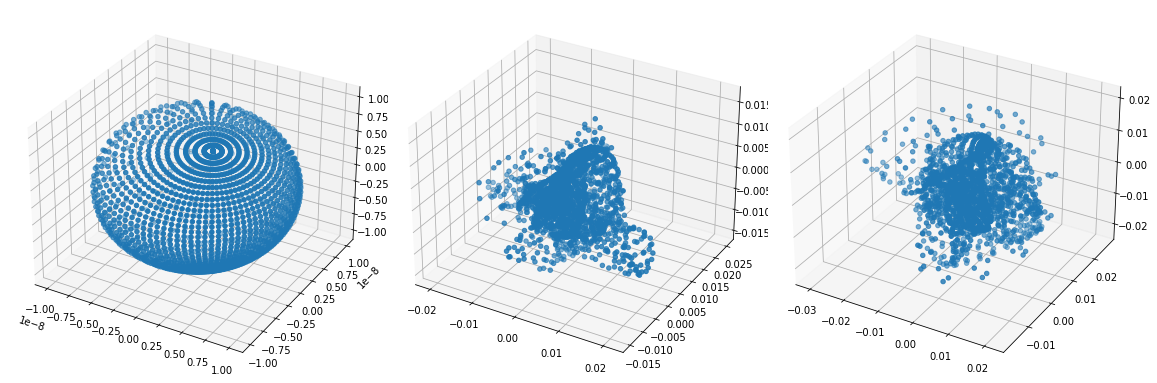

In [23]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(listpq[0,0,:], listpq[0,1,:], listpq[0,2,:])

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(listpq[1,0,:], listpq[1,1,:], listpq[1,2,:])

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(listpq[2,0,:], listpq[2,1,:], listpq[2,2,:])

plt.tight_layout()
plt.show()

In [24]:
listpq = []
for t in range(f_stoch_x.shape[0]):
    (x_coord_stoch, y_coord_stoch, z_coord_stoch) = x_list[t], y_list[t], z_list[t]
    listpq.append([x_coord_stoch, y_coord_stoch, z_coord_stoch])
        
listpq = np.array(listpq)

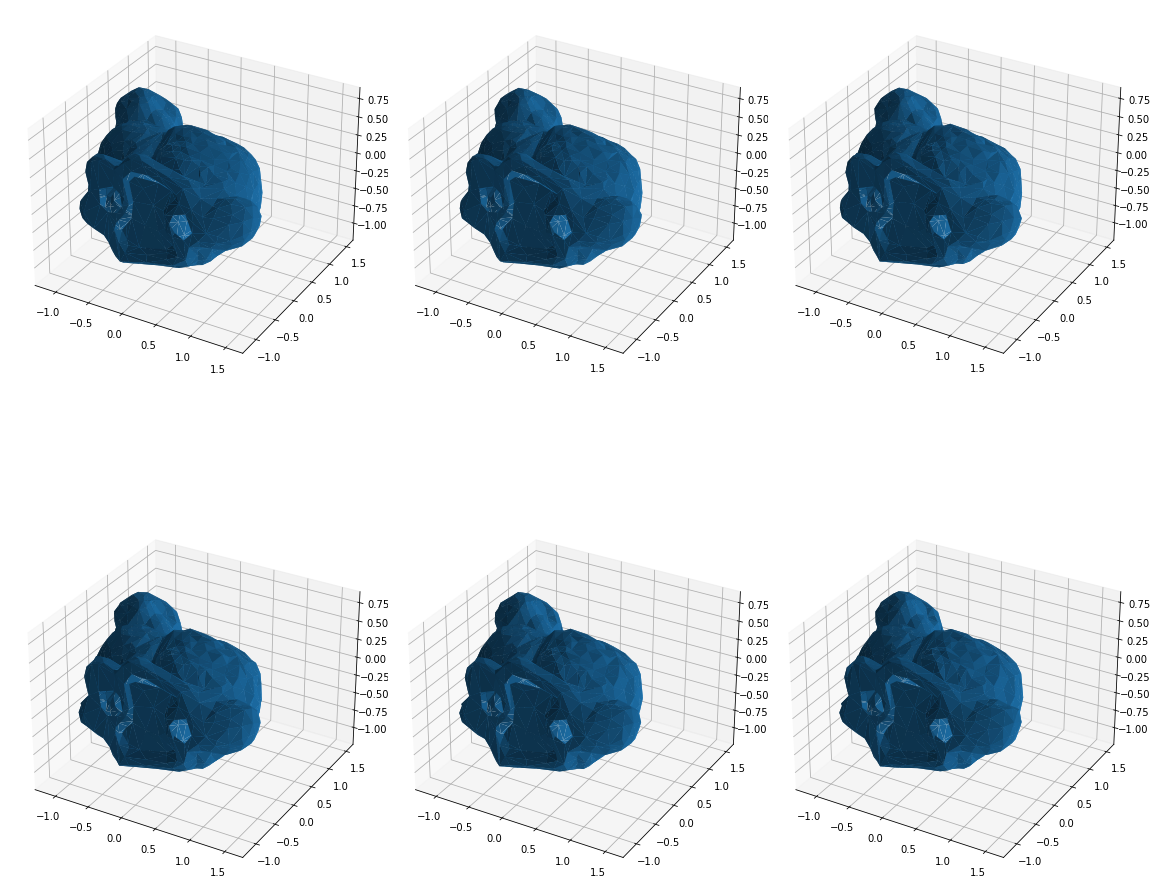

In [25]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(231, projection='3d')
ax1.plot_trisurf(listpq[0,0,:], listpq[0,1,:], triangles=new_mesh_F, Z=listpq[0,2,:])

ax2 = fig.add_subplot(232, projection='3d')
ax2.plot_trisurf(listpq[1,0,:], listpq[1,1,:], triangles=new_mesh_F, Z=listpq[1,2,:])

ax3 = fig.add_subplot(233, projection='3d')
ax3.plot_trisurf(listpq[2,0,:], listpq[2,1,:], triangles=new_mesh_F, Z=listpq[2,2,:])

ax4 = fig.add_subplot(234, projection='3d')
ax4.plot_trisurf(listpq[3,0,:], listpq[3,1,:], triangles=new_mesh_F, Z=listpq[3,2,:])

ax5 = fig.add_subplot(235, projection='3d')
ax5.plot_trisurf(listpq[4,0,:], listpq[4,1,:], triangles=new_mesh_F, Z=listpq[4,2,:])

ax6 = fig.add_subplot(236, projection='3d')
ax6.plot_trisurf(listpq[5,0,:], listpq[5,1,:], triangles=new_mesh_F, Z=listpq[5,2,:])

plt.tight_layout()
plt.show()

In [27]:
list_data = listpq
file_dir = "tests/bunny_process_aligned"
file_name = "Q_identity_49coeffs.gif"
auto_scale = True

from matplotlib.collections import PolyCollection
import imageio

In [28]:
filenames = []
listpq = list_data
steps = []
#setting up the faces for the mesh
#rows_unique = np.unique(listpq[0,:,:].T, axis=0, return_index=True)
#new = listpq[0,:,:].T[rows_unique[1]]
#hull = tri.convex.convex_hull(new, qhull_options='QbB Pp Qt QJ')
faces = new_mesh_F
#for i in range(listpq.shape[0]):
#    steps.append(listpq[i,:,:].T[rows_unique[1]])
#steps = np.array(steps)
if not auto_scale:
    scale = np.max(listpq[i,:,:].max(0)-listpq[i,:,:].min(0))
    
for i in range(len(listpq)):

    def frustum(left, right, bottom, top, znear, zfar):
        M = np.zeros((4, 4), dtype=np.float32)
        M[0, 0] = +2.0 * znear / (right - left)
        M[1, 1] = +2.0 * znear / (top - bottom)
        M[2, 2] = -(zfar + znear) / (zfar - znear)
        M[0, 2] = (right + left) / (right - left)
        M[2, 1] = (top + bottom) / (top - bottom)
        M[2, 3] = -2.0 * znear * zfar / (zfar - znear)
        M[3, 2] = -1.0
        return M
    def perspective(fovy, aspect, znear, zfar):
        h = np.tan(0.5*np.radians(fovy)) * znear
        w = h * aspect
        return frustum(-w, w, -h, h, znear, zfar)
    def translate(x, y, z):
        return np.array([[1, 0, 0, x], [0, 1, 0, y],
                         [0, 0, 1, z], [0, 0, 0, 1]], dtype=float)
    def xrotate(theta):
        t = np.pi * theta / 180
        c, s = np.cos(t), np.sin(t)
        return np.array([[1, 0,  0, 0], [0, c, -s, 0],
                         [0, s,  c, 0], [0, 0,  0, 1]], dtype=float)
    def yrotate(theta):
        t = np.pi * theta / 180
        c, s = np.cos(t), np.sin(t)
        return  np.array([[ c, 0, s, 0], [ 0, 1, 0, 0],
                          [-s, 0, c, 0], [ 0, 0, 0, 1]], dtype=float)

    def zrotate(theta):
        t = np.pi * theta / 180
        c, s = np.cos(t), np.sin(t)
        return  np.array([[ c, -s, 0, 0], [ s, c, 0, 0],
                          [0, 0, 1, 0], [ 0, 0, 0, 1]], dtype=float)

    V = np.array(listpq[i,:,:]).T
    #V = np.array([it[:,0], it[:,1], it[:,2]]).T
    F = np.array([faces[:,0], faces[:,1], faces[:,2]]).T

    if auto_scale:
        V = (V-(V.max(0)+V.min(0))/2)/max(V.max(0)-V.min(0))
    else:
        V = (V-(V.max(0)+V.min(0))/2)/scale
    MVP = perspective(25,1,1,100) @ translate(0,0,-3.5) @ xrotate(20) @ yrotate(20) @ zrotate(-10)
    V = np.c_[V, np.ones(len(V))]  @ MVP.T
    V /= V[:,3].reshape(-1,1)
    V = V[F]
    T =  V[:,:,:2]
    Z = -V[:,:,2].mean(axis=1)
    zmin, zmax = Z.min(), Z.max()
    Z = (Z-zmin)/(zmax-zmin)
    C = plt.get_cmap("magma")(Z)
    I = np.argsort(Z)
    T, C = T[I,:], C[I,:]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)
    collection = PolyCollection(T, closed=True, linewidth=0.1, facecolor=C, edgecolor="black")
    ax.add_collection(collection)
    
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # last frame of each viz stays longer
    if (i == len(listpq)-1):
            for i in range(5):
                filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()# build gif
        
if not os.path.exists(file_dir):
    os.makedirs(file_dir)
    
with imageio.get_writer(os.path.join(file_dir,file_name), mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
    # Remove files
for filename in set(filenames):
    os.remove(filename)

/tmp/ipykernel_102/3731768164.py:93: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## Optimization with metaheuristics

In [64]:
import torch
import time
from torch.autograd import grad

# torch type and device
use_cuda = torch.cuda.is_available()
torchdeviceId = torch.device("cuda:0") if use_cuda else "cpu"
torchdtype = torch.float32

VS = np.hstack((my_coeffs_x, my_coeffs_y, my_coeffs_z))
VT = new_mesh_V
q0 = torch.from_numpy(VS)
q0 = q0.clone().detach().to(dtype=torchdtype, device=torchdeviceId).requires_grad_(True)
#p0 = torch.from_numpy(np.zeros(q0.shape[0]))

In [65]:
new_mesh_V

array([[-0.11414344,  0.47267284, -0.05910063],
       [-0.28782556,  0.5067438 , -0.09988711],
       [-0.65770415,  0.86986016,  0.50695189],
       ...,
       [-0.05923922,  0.90762811, -0.19318115],
       [-0.73639814,  0.8536739 , -0.82383067],
       [-0.740594  ,  0.75430177, -0.36458137]])

Text(0.5, 0.92, 'Shape comparison')

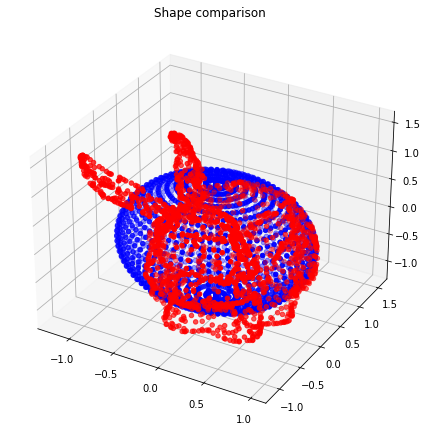

In [66]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x, y, z, c='b')
ax1.scatter(new_mesh_V[:,2], new_mesh_V[:,0], new_mesh_V[:,1], c='r')
ax1.set_title("Shape comparison")

In [67]:
def varifold_dist(mesh1, mesh2, sigma):
    
    use_cuda = torch.cuda.is_available()
    torchdeviceId = torch.device("cuda:0") if use_cuda else "cpu"
    torchdtype = torch.float32

    # PyKeOps counterpart
    KeOpsdeviceId = torchdeviceId.index  # id of Gpu device (in case Gpu is  used)
    KeOpsdtype = torchdtype.__str__().split(".")[1]  # 'float32'
    
    V1, F1 = np.array(mesh1.vertices), np.array(mesh1.faces)
    V2, F2 = np.array(mesh2.vertices), np.array(mesh2.faces)
    
    q0 = torch.from_numpy(V1).clone().detach().to(dtype=torchdtype, device=torchdeviceId).requires_grad_(True)
    VT = torch.from_numpy(V2).clone().detach().to(dtype=torchdtype, device=torchdeviceId)
    FS = torch.from_numpy(F1).clone().detach().to(dtype=torch.long, device=torchdeviceId)
    FT = torch.from_numpy(F2).clone().detach().to(dtype=torch.long, device=torchdeviceId)
    sigma = torch.tensor([sigma], dtype=torchdtype, device=torchdeviceId)
    
    p0 = torch.zeros(q0.shape, dtype=torchdtype, device=torchdeviceId, requires_grad=True)
    dataloss = lddmm_utils.lossVarifoldSurf(FS, VT, FT, lddmm_utils.GaussLinKernel(sigma=sigma))
    Kv = lddmm_utils.GaussKernel(sigma=sigma)
    loss = lddmm_utils.LDDMMloss(Kv, dataloss)

    dist = loss(p0, q0)

    return(dist)

In [68]:
varifold_dist(hull, new_mesh, sigma= 10**(-2)).item()

0.25081124901771545

In [69]:
### loss
def loss(q0):
    
    coeffs_x, coeffs_y, coeffs_z = q0[:n], q0[n:2*n], q0[2*n:]
    
    my_reconstr_function_x = my_basis.sph_harm_reconstruct(coeffs_x)
    my_reconstr_function_y = my_basis.sph_harm_reconstruct(coeffs_y)
    my_reconstr_function_z = my_basis.sph_harm_reconstruct(coeffs_z)
    
    f_recons_x = my_reconstr_function_x(theta,phi)
    f_recons_y = my_reconstr_function_y(theta,phi)
    f_recons_z = my_reconstr_function_z(theta,phi)
    (x_coord_recons, y_coord_recons, z_coord_recons) = f_recons_x, f_recons_y, f_recons_z
    
    listpq = np.array([x_coord_recons, y_coord_recons, z_coord_recons])
    points = listpq.T[rows_unique[1]]
    mesh_recons = tri.Trimesh(vertices = points, faces = faces)
    
    res = varifold_dist(mesh_recons, new_mesh, sigma = 10**(-2)).item()
    print(res)
    
    return(res)

In [70]:
x0 = np.array(my_coeffs_x + my_coeffs_y + my_coeffs_z)

In [71]:
loss(x0)

0.25081124901771545


0.25081124901771545

In [72]:
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
lw = [-10] * 3*n
up = [10] * 3*n

In [73]:
opt = minimize(loss, x0 = x0, method='L-BFGS-B', tol=1e-2, options = {'maxiter': 100})
opt = dual_annealing(loss, bounds=list(zip(lw, up)), maxiter=10, x0 = x0)

0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545
0.25081124901771545


729.080810546875
584.8828125
1089.1820068359375
601.0493774414062
5219.0126953125
9332.5966796875
12127.7666015625
5568.18359375
3777.529296875
5306.5888671875
5055.8232421875
5451.77685546875
12895.900390625
8368.25390625
11719.142578125
9805.576171875
8483.5146484375
6119.94482421875
15460.75
6135.7578125
5239.1943359375
4179.1591796875
8181.60302734375
3951.77587890625
9686.8818359375
15126.7822265625
8854.2802734375
9399.736328125
2640.19140625
1934.3692626953125
6414.787109375
2270.62744140625
4302.470703125
1653.1129150390625
8494.716796875
9292.5322265625
11636.8095703125
8737.1171875
7355.6982421875
10886.2314453125
15010.6484375
15810.35546875
4372.55859375
6638.21826171875
9126.140625
9892.40234375
4798.29296875
7177.86474609375
15111.5546875
3424.65966796875
14368.759765625
4257.390625
601.0493774414062
599.3417358398438
725.9140625
672.1968383789062
616.5330810546875
629.5158081054688
704.0401000976562
639.3378295898438
734.0221557617188
854.8800048828125
834.244140625
610.

10164.9765625
19225.529296875
3501.736328125
6161.4326171875
4381.4921875
1426.5908203125
9916.080078125
2455.65576171875
12551.12109375
4403.34521484375
12123.404296875
5885.48828125
2142.3740234375
13375.56640625
7898.62353515625
5037.6455078125
3316.831787109375
6726.2333984375
6455.09716796875
920.9306030273438
3111.939208984375
7192.4609375
10366.70703125
7400.65234375
7165.37158203125
12655.54296875
11709.873046875
4685.95947265625
4851.2080078125
14450.3779296875
3782.88525390625
8088.97412109375
11703.564453125
3978.246337890625
6808.0947265625
2757.2431640625
6748.25390625
3638.23095703125
3088.189453125
4666.154296875
11212.515625
7846.3369140625
8613.576171875
49.20930099487305
67.91221618652344
48.887298583984375
99.80939483642578
79.95175170898438
76.47120666503906
98.8876724243164
71.16255187988281
59.55221939086914
80.49549102783203
52.71371841430664
151.44337463378906
45.96147537231445
96.6815414428711
130.4574432373047
56.734683990478516
45.96147155761719
55.6441230773

In [74]:
loss(opt.x)

0.25081124901771545


0.25081124901771545

In [75]:
opt.x

array([ 7.71933149e-17, -2.12442528e-17, -8.94119047e-18,  2.04665342e+00,
        2.21666244e-16,  4.97599455e-18, -2.35379651e-17,  4.46833587e-17,
       -2.44747977e-16, -5.43776806e-16, -1.34351798e-17,  2.90964981e-18,
       -8.86395648e-19, -3.26987672e-16, -4.56200879e-18,  4.42224069e-16,
        1.01630606e-16,  2.04665342e+00,  1.61202348e-19, -3.13453169e-17,
        5.40660305e-17,  7.96437978e-18, -2.43204544e-17,  1.52797557e-17,
        6.16207073e-17,  4.65985268e-16,  3.02205588e-18, -3.26987672e-16,
        4.34310168e-18, -1.04689253e-17,  7.31977860e-18, -5.21585029e-16,
        8.71307589e-17, -9.39618279e-19,  2.04665342e+00,  9.57601280e-18,
        2.78073258e-18,  9.45485073e-17,  5.47915361e-16,  1.06315512e-16,
        1.82189631e-17,  4.28518930e-19, -6.51393920e-17,  6.43218257e-18,
       -1.08995891e-16,  2.94488825e-18, -1.67678023e-16,  2.85258268e-18])

In [76]:
coeffs_x, coeffs_y, coeffs_z = opt.x[:n], opt.x[n:2*n], opt.x[2*n:]

my_reconstr_function_x = my_basis.sph_harm_reconstruct(coeffs_x)
my_reconstr_function_y = my_basis.sph_harm_reconstruct(coeffs_y)
my_reconstr_function_z = my_basis.sph_harm_reconstruct(coeffs_z)
f_recons_x = my_reconstr_function_x(theta,phi)
f_recons_y = my_reconstr_function_y(theta,phi)
f_recons_z = my_reconstr_function_z(theta,phi)

(x_coord_recons, y_coord_recons, z_coord_recons) = f_recons_x, f_recons_y, f_recons_z
estim = tri.Trimesh(vertices = np.array([x_coord_recons, y_coord_recons, z_coord_recons]).T, faces = faces)

In [77]:
varifold_dist(estim, new_mesh, sigma= 10**(-2)).item()

nan

Text(0.5, 0.92, 'Shape reconstr')

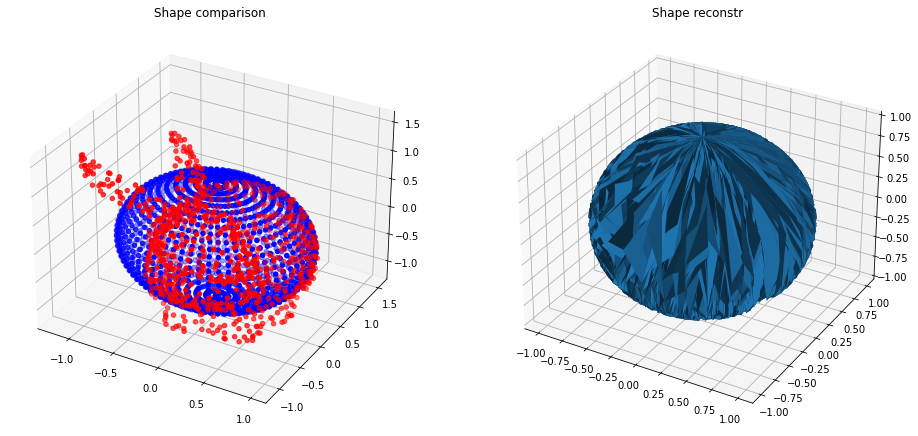

In [78]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_coord_recons, y_coord_recons, z_coord_recons, c='b')
ax1.scatter(new_mesh.vertices[:,2], new_mesh.vertices[:,0], new_mesh.vertices[:,1], c='r')
ax1.set_title("Shape comparison")

ax1 = fig.add_subplot(122, projection='3d')
ax1.plot_trisurf(x_coord_recons, y_coord_recons, triangles = faces, Z = z_coord_recons)

ax1.set_title("Shape reconstr")

## Optimization with auto grad

In [41]:
optimizer = torch.optim.LBFGS([q0], max_eval=10, max_iter=10)
print("performing optimization...")
start = time.time()

def closure():
    optimizer.zero_grad()
    L = loss(q0)
    print("loss", L.detach().cpu().numpy()[0])
    L.backward(retain_graph=True)
    return L

for i in range(10):
    print("it ", i, ": ", end="")
    optimizer.step(closure)

print("Optimization (L-BFGS) time: ", round(time.time() - start, 2), " seconds")

performing optimization...
it  0 : loss 89.95886
it  1 : loss 89.95886
it  2 : loss 89.95886
it  3 : loss 89.95886
it  4 : loss 89.95886
it  5 : loss 89.95886
it  6 : loss 89.95886
it  7 : loss 89.95886
it  8 : loss 89.95886
it  9 : loss 89.95886
Optimization (L-BFGS) time:  1.64  seconds
